# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/Earth1270/intro-to-ml-tensorflow/blob/WorkingCopy/projects/p2_image_classifier/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

###_Rubric_
_All the necessary packages and modules are imported at the beginning of the notebook._

In [1]:
# TODO: Make all necessary imports.

import warnings
warnings.filterwarnings('ignore')

import time
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import json as json
import glob
import os
import shutil
from PIL import Image
import random

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks")
print('Working Directory: {}'.format(os.getcwd()))

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('\n Using:')
print('\t\u2022 Tensorflow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')


Mounted at /content/drive
Working Directory: /content/drive/MyDrive/Colab Notebooks

 Using:
	• Tensorflow version: 2.8.0
	• tf.keras version: 2.8.0
	• Running on GPU


In [4]:
#Misc Parameters
IMG = 224 #image size
BATCH = 32 #batch size

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

###_Rubric_
_The Oxford Flowers 102 dataset is loaded using TensorFlow Datasets._  
_The dataset is divided into a training set, a validation set, and a test set._  
Derived from lecture examples 

In [14]:
# TODO: Load the dataset with TensorFlow Datasets.
data, metadata = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# TODO: Create a training set, a validation set and a test set.
train, test, validate = data['train'], data['test'], data['validation']

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteFX3ECD/oxford_flowers102-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteFX3ECD/oxford_flowers102-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteFX3ECD/oxford_flowers102-validation.tfrecord
Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Explore the Dataset

###_Rubric_  
_The number of examples in each set and the number classes in the dataset are extracted from the dataset info._  
Derived from lecture examples

In [16]:
# TODO: Get the number of examples in each set from the dataset info.
train_size, test_size, validate_size = metadata.splits['train'].num_examples, metadata.splits['test'].num_examples, metadata.splits['validation'].num_examples
print('\nDataset Sizes:')
print('\t\u2022 Training: ', train_size, '\n\t\u2022 Testing: ', test_size, '\n\t\u2022 Validation: ', validate_size)

# TODO: Get the number of classes in the dataset from the dataset info.
classes = metadata.features['label'].num_classes
print('\nNumber of Classes: ', classes)


Dataset Sizes:
	• Training:  1020 
	• Testing:  6149 
	• Validation:  1020

Number of Classes:  102


###_Rubric_  
_The shape of the first 3 images in the training set is printed using a for loop and the take() method._  
Derived from lecture examples

In [21]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
n=1
for image, label in train.take(3):
  print('\nShape and Label for Image {}:'.format(n))
  print('\t\u2022  Shape: {}'.format(image.shape))
  print('\t\u2022  Label: {}'.format(label))
  n +=1


Shape and Label for Image 1:
	•  Shape: (500, 667, 3)
	•  Label: 72

Shape and Label for Image 2:
	•  Shape: (500, 666, 3)
	•  Label: 84

Shape and Label for Image 3:
	•  Shape: (670, 500, 3)
	•  Label: 70


###_Rubric_  
_The first image from the training set is plotted with the title of the plot corresponding to the image label._  
Derived from lecture examples

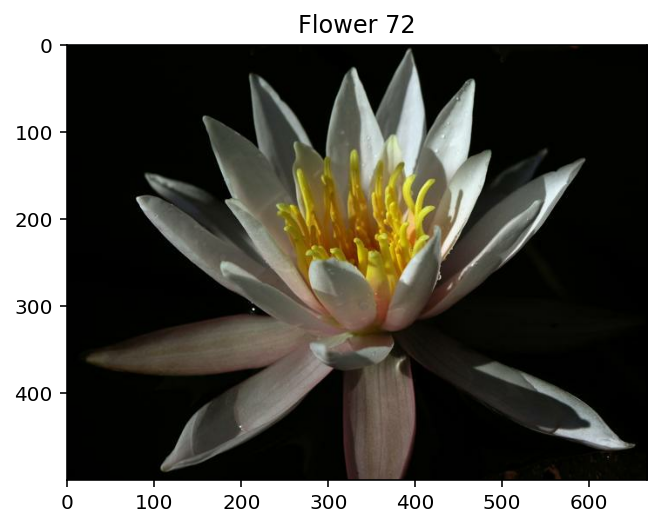

In [22]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in train.take(1):
  ttl = "Flower " + str(label.numpy())
  plt.imshow(image)
  plt.title(ttl)
  plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [23]:
#Load class_names file
with open('label_map.json', 'r') as f:
  class_names = json.load(f)

###_Rubric_
_The first image from the training set is plotted with the title of the plot corresponding to the class name using label mapping from the JSON file._  
Derived from lecture examples; +1 req from mentor help

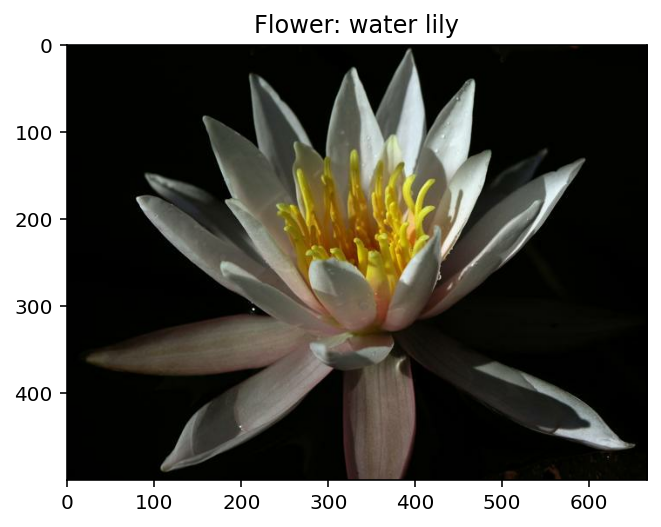

In [24]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
#per mentor notes, add 1 to reconcile coding

for image, label in train.take(1):
  ttl = "Flower: " + class_names[str(label.numpy()+1)]
  plt.imshow(image)
  plt.title(ttl)
  plt.show()

## Create Pipeline

###_Rubric_
_The training, validation, and testing data is appropriately resized and normalized._  
_A pipeline for each set is constructed with the necessary transformations._  
_The pipeline for each set should return batches of images._  
Derived from lecture examples

In [25]:
# TODO: Create a pipeline for each set.

def normalize_input(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG, IMG))
  image /= 255
  return image, label

train_batch = train.shuffle(train_size//4).map(normalize_input).batch(BATCH).prefetch(1)
validation_batch = validate.map(normalize_input).batch(BATCH).prefetch(1)
test_batch = test.map(normalize_input).batch(BATCH).prefetch(1)

for image_batch, label_batch in train_batch.take(1):
  print('\nShape of training image and label batches:')
  print('\t\u2022 Image batches:{}'.format(image_batch.shape))
  print('\t\u2022 Label batches: {}'.format(label_batch.shape))


Shape of training image and label batches:
	• Image batches:(32, 224, 224, 3)
	• Label batches: (32,)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

###_Rubric_
_The pre-trained network, MobileNet, is loaded using TensorFlow Hub and its parameters are frozen._  
Derived from lecture examples

In [26]:
# TODO: Build and train your network.
#List url, define feature_extractor with input shape
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(url, input_shape=(IMG, IMG, 3))
feature_extractor_trainable=False

###_Rubric_
_A new neural network is created using transfer learning. The number of neurons in the output layer should correspond to the number of classes of the dataset._  
Derived from lecture examples

In [27]:
#Build Sequential model with extractor, softmax activation, and print summary
#output 102 nodes corresponding to count in class_names
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dense(classes, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


###_Rubric_
_The model is configured for training using the compile method with appropriate parameters. The model is trained using the fit method and incorporating the validation set._  
Derived from lecture examples

In [28]:
#Use optimizer, loss function, and metric per class example:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

#save random weights to allow re-runs during optimization
model.save_weights("./model_with_saved_weights.h5")

#Use 100 epochs with early_stopping 
EPOCHS = 100
#metric to val-accuracy 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience = 6,
                                                  mode='max',
                                                  #min_delta=1
                                                  )
#Add interim model saves:
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_accuracy',
                                               mode='max',
                                               verbose=1,
                                               save_best_only=True)


In [29]:
#Fit the model
history = model.fit(train_batch, 
                    epochs=EPOCHS,
                    validation_data = validation_batch,
                    callbacks=[save_best, early_stopping]
                    ) 


Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 4.2496 - accuracy: 0.1196
Epoch 1: val_accuracy improved from -inf to 0.39804, saving model to ./best_model.h5
32/32 [==============================] - 14s 286ms/step - loss: 4.2496 - accuracy: 0.1196 - val_loss: 3.0756 - val_accuracy: 0.3980
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 2.0275 - accuracy: 0.7059
Epoch 2: val_accuracy improved from 0.39804 to 0.66373, saving model to ./best_model.h5
32/32 [==============================] - 8s 252ms/step - loss: 2.0275 - accuracy: 0.7059 - val_loss: 1.9924 - val_accuracy: 0.6637
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.8990
Epoch 3: val_accuracy improved from 0.66373 to 0.72549, saving model to ./best_model.h5
32/32 [==============================] - 9s 261ms/step - loss: 1.0719 - accuracy: 0.8990 - val_loss: 1.5302 - val_accuracy: 0.7255
Epoch 4/100
32/32 [==============================] - ETA: 0s

###_Rubric_
_The loss and accuracy values achieved during training for the training and validation set are plotted using the history dictionary return by the fit method._  
Derived from lecture examples

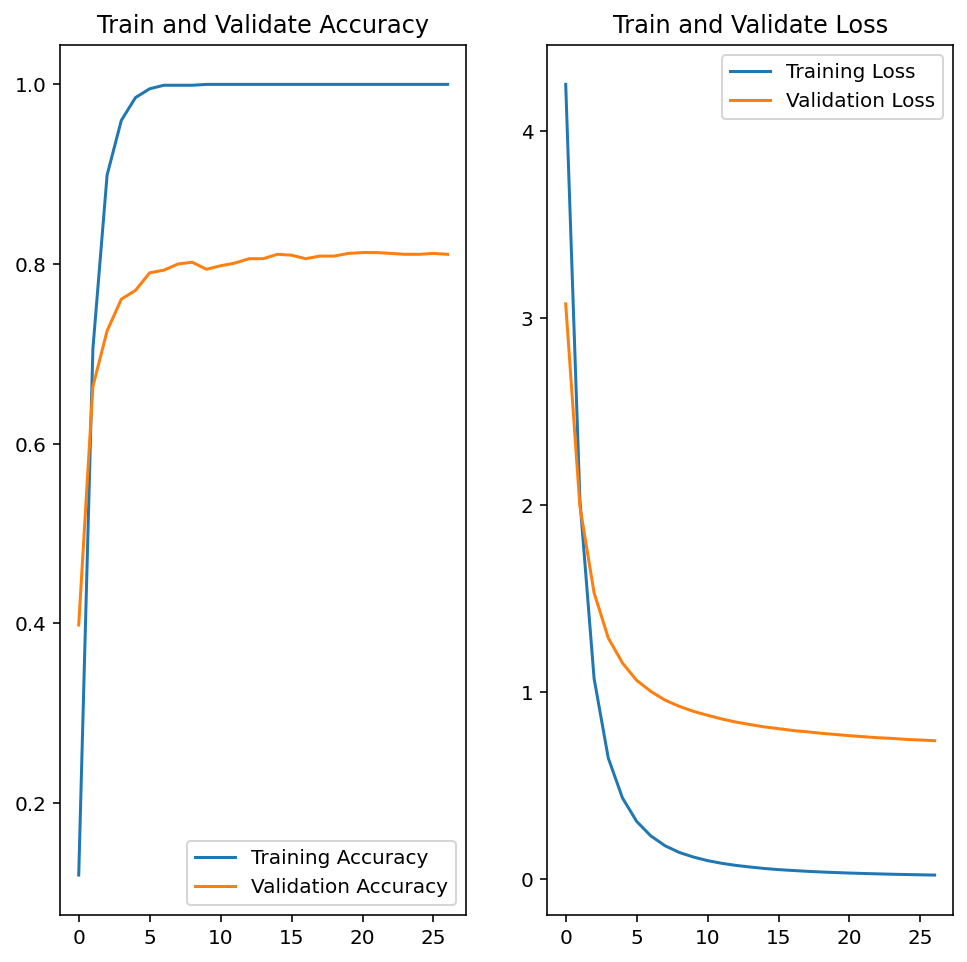

In [30]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
#Plots per class example, Part 5 Inference and Validation
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(len(training_accuracy)) 
#use training_accuracy lengths rather than EPOCHS since applying early_stopping

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy, label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validate Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Validate Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

###_Rubric_
_The network's accuracy is measured on the test data._  
Derived from lecture examples

In [31]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(test_batch)
print('\nTest Data Loss and Accuracy with Final Model:')
print('\t\u2022 Loss: {:,.4f}'.format(loss))
print("\t\u2022 Accuracy: {:.2%}".format(accuracy))
final_model_accuracy = accuracy

193/193 [==============================] - 24s 124ms/step - loss: 0.8571 - accuracy: 0.7887

Test Data Loss and Accuracy with Final Model:
	• Loss: 0.8571
	• Accuracy: 78.87%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

###_Rubric_
_The trained model is saved as a Keras model (i.e. saved as an HDF5 file with extension .h5)._  
Derived from lecture examples

In [32]:
# TODO: Save your trained model as a Keras model.
#save in a folder with time stamp on google drive
import time
t = time.time()

#SavedModels format:
Saved_Model = './{}.h5'.format(int(t))
#apply save method from error note on reload/predict
tf.keras.models.save_model(model, Saved_Model)

#save model name to file so model can be retrieved:
text_file = open("file_name.txt", "w")
text_file.write(str(int(t)))
text_file.close()


In [ ]:
#Run this if re-iterating through the model to reload saved fully randomized weights
dir=os.getcwd()
dir= dir + '/model_with_saved_weights.h5'
model.load_weights(dir)

## Load the Keras Model

Load the Keras model you saved above.

###_Rubric_
_The saved Keras model is successfully loaded._  
Derived from lecture examples

In [33]:
# TODO: Load the Keras model
# Loading from the model copy saved to drive

#use saved string to identify latest file
with open('file_name.txt', 'r') as f:
    file_base = f.readlines()
file_name = str(file_base[0]) + '.h5'
#Reload the model
Reloaded_Saved_Model = tf.keras.models.load_model(file_name, custom_objects = {'KerasLayer':hub.KerasLayer})

#Reloaded_Saved_Model = tf.keras.models.load_model(Saved_Model, custom_objects = {'KerasLayer':hub.KerasLayer})

#test Reloaded_Saved_Model accuracy
loss, accuracy = Reloaded_Saved_Model.evaluate(test_batch)
print('\nTest Data Loss and Accuracy with Reloaded Final Model:')
print('\t\u2022 Loss: {:,.4f}'.format(loss))
print("\t\u2022 Accuracy: {:.2%}".format(accuracy))

equal_test = accuracy == final_model_accuracy
print("\nDoes Reloaded Model Accuracy equal Original Model Accuracy?: ", equal_test)

final_model_loss = loss

193/193 [==============================] - 24s 123ms/step - loss: 0.8571 - accuracy: 0.7887

Test Data Loss and Accuracy with Reloaded Final Model:
	• Loss: 0.8571
	• Accuracy: 78.87%

Does Reloaded Model Accuracy equal Original Model Accuracy?:  True


In [34]:
#Compare 'best_model.h5' accuracy/loss to saved model
#No need to run this step again: final model is always outperforming best model
Best_Model = tf.keras.models.load_model("best_model.h5", custom_objects = {'KerasLayer':hub.KerasLayer})

#test Reloaded_Saved_Model accuracy
loss, accuracy = Best_Model.evaluate(test_batch)
print('\nTest Data Loss and Accuracy with Best Model:')
print('\t\u2022Loss: {:,.4f}'.format(loss))
print("\t\u2022Accuracy: {:.2%}".format(accuracy))

print('\nCompare Final Model Outcomes with Best Model Outcomes:')
print('\t\u2022 Accuracy Best - Final Model: {:,.4%}'.format(accuracy - final_model_accuracy))
print('\t\u2022 Loss Best - Final Model: {:,.4f}'.format(loss - final_model_loss))
print('Final model always slightly out-performs best_model')

193/193 [==============================] - 24s 121ms/step - loss: 0.8832 - accuracy: 0.7860

Test Data Loss and Accuracy with Best Model:
	•Loss: 0.8832
	•Accuracy: 78.60%

Compare Final Model Outcomes with Best Model Outcomes:
	• Accuracy Best - Final Model: -0.2765%
	• Loss Best - Final Model: 0.0261
Final model always slightly out-performs best_model


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

###_Rubric_ 
_The process_image function successfully normalizes and resizes the input image. The image returned by the process_image function should be a NumPy array with shape (224, 224, 3)._  
Method described above

In [6]:
# TODO: Create the process_image function
def process_image(image):
  image=tf.convert_to_tensor(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMG, IMG))
  image /= 255
  return image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 


 Image Shape Before and After Processing:
	• Shape Before Processing: (591, 500, 3)
	• Shape After Processing:  (224, 224, 3)




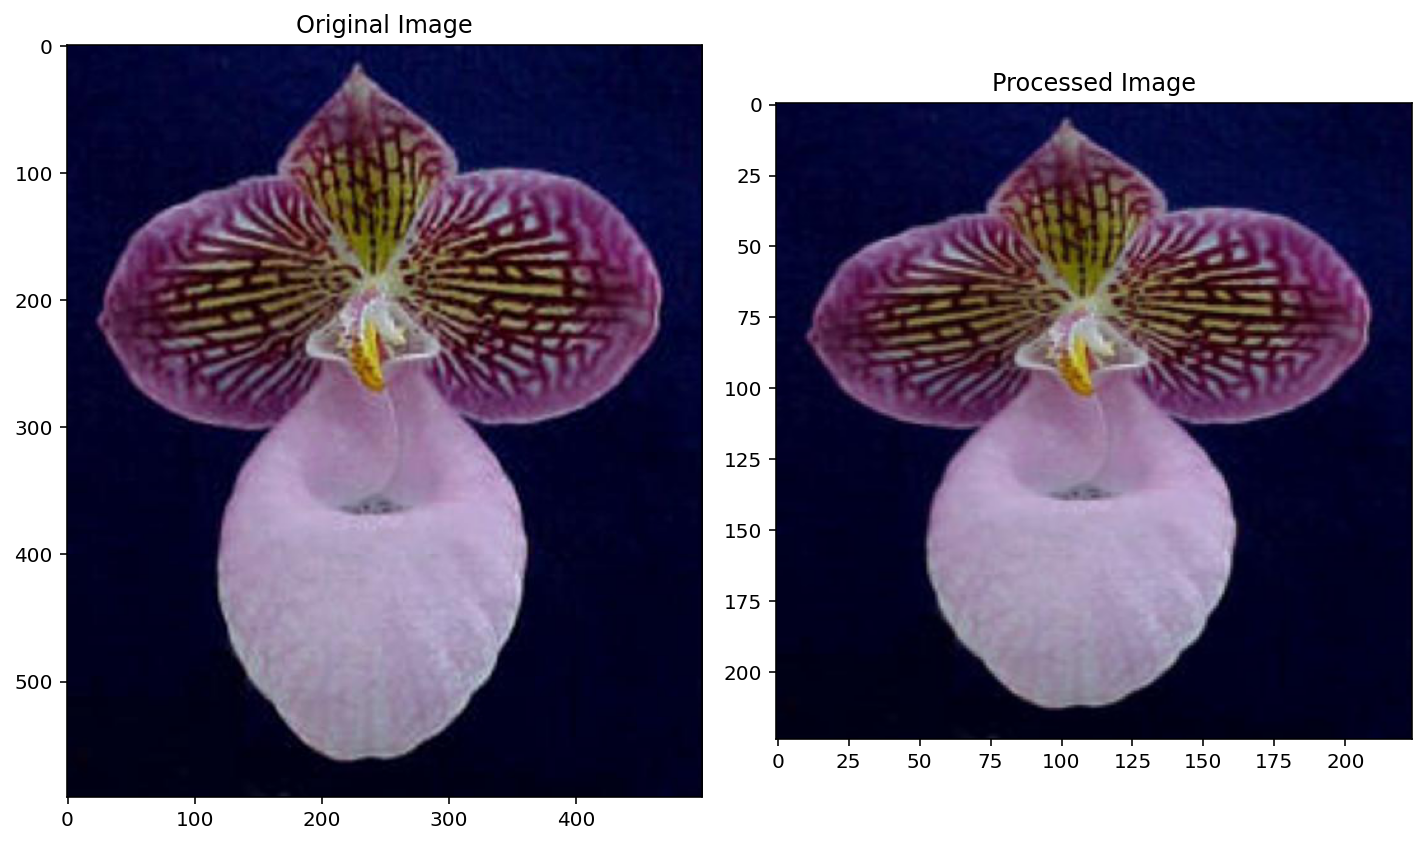

In [ ]:
#run this step only to verify that resizing has worked in process_image
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)
print('\n Image Shape Before and After Processing:')
print('\t\u2022 Shape Before Processing: {}'.format(test_image.shape))
processed_test_image = process_image(test_image)
print('\t\u2022 Shape After Processing:  {}'.format(processed_test_image.shape))
print('\n')

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

###_Rubric_
The predict function successfully takes the path to an image and a saved model, and then returns the top K most probably classes for that image.  
Method described above and discussed in mentor help.

In [35]:
# TODO: Create the predict function

def predict(image_path, model, top_k):
  image = Image.open(image_path)
  image = np.asarray(image)
  image = process_image(image)
  image_extra_dim = np.expand_dims(image, axis=0)
  y_pred = model.predict(image_extra_dim)
  
  top_k_values, top_k_indices = tf.nn.top_k(y_pred, k=top_k)
  top_k_indices = 1 + top_k_indices[0] #add 1 to index, per mentor help
    
  return top_k_values.numpy()[0], top_k_indices.numpy().astype(str), image


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='https://github.com/Earth1270/intro-to-ml-tensorflow/blob/WorkingCopy/projects/p2_image_classifier/assets/inference_example.png?raw=1' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

Add methods to allow loading, predicting from saved files: Model_Load(), load_class_names()

In [36]:
#Reload model using a filename stored as a string in a file
#Allows model load without variable in memory and without record of file name
#Allows load of 'best_model.h5'
def Model_Load(last_model="Saved"): 
  last_model = last_model.lower
  if last_model=='best':
    file_name = "best_model.h5" #load best_model if 'best' passed in call
  else:
    with open('file_name.txt', 'r') as f:
      file_base = f.readlines()
    file_name = str(file_base[0]) + '.h5'
  model = tf.keras.models.load_model(file_name, custom_objects = {'KerasLayer':hub.KerasLayer})
  return model

In [37]:
#Reload and decode class_names with json.load()
def load_class_names():
  with open('label_map.json', 'r') as f:
    class_names = json.load(f)
  return class_names

In [38]:
#assign label to each predicted class
def label_class(classes):
  class_label = []
  for num_class in classes:
    class_label.append(class_names[num_class].title())
  return class_label

###_Rubric_
_A matplotlib figure is created displaying an image and its associated top 5 most probable classes with actual flower names._  
Code adapted from earlier image print.

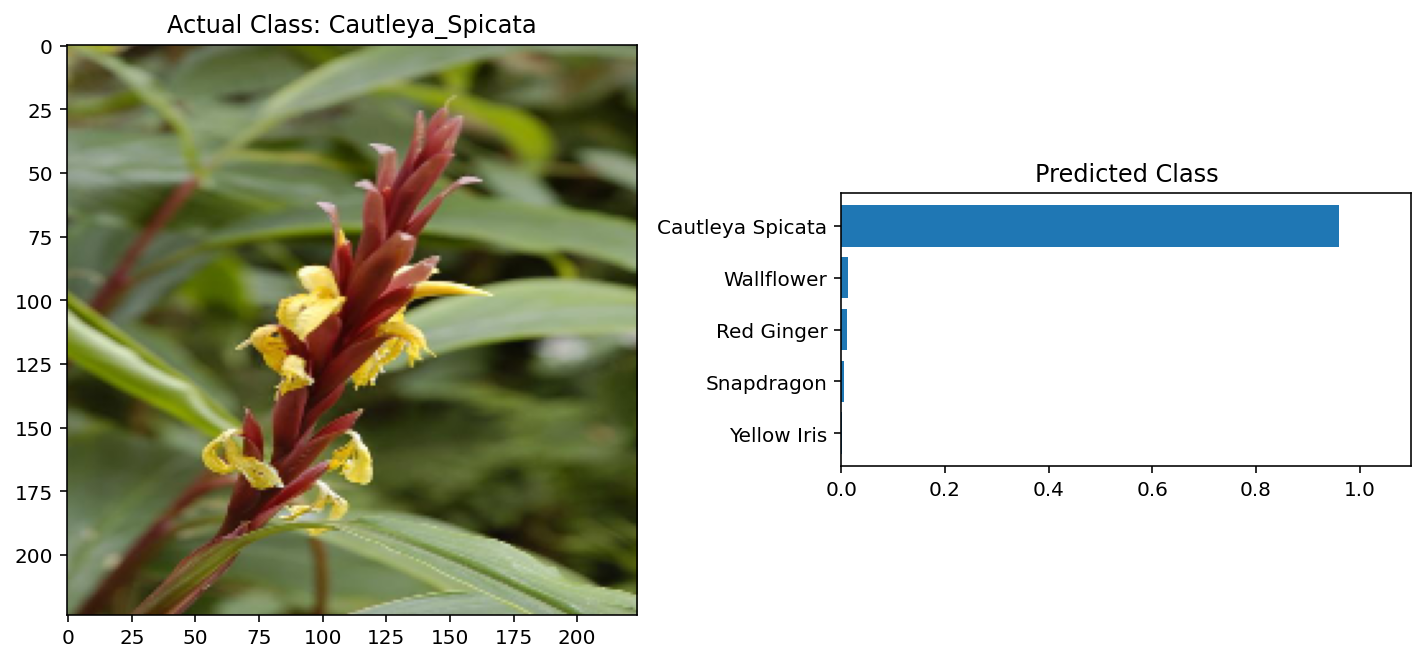

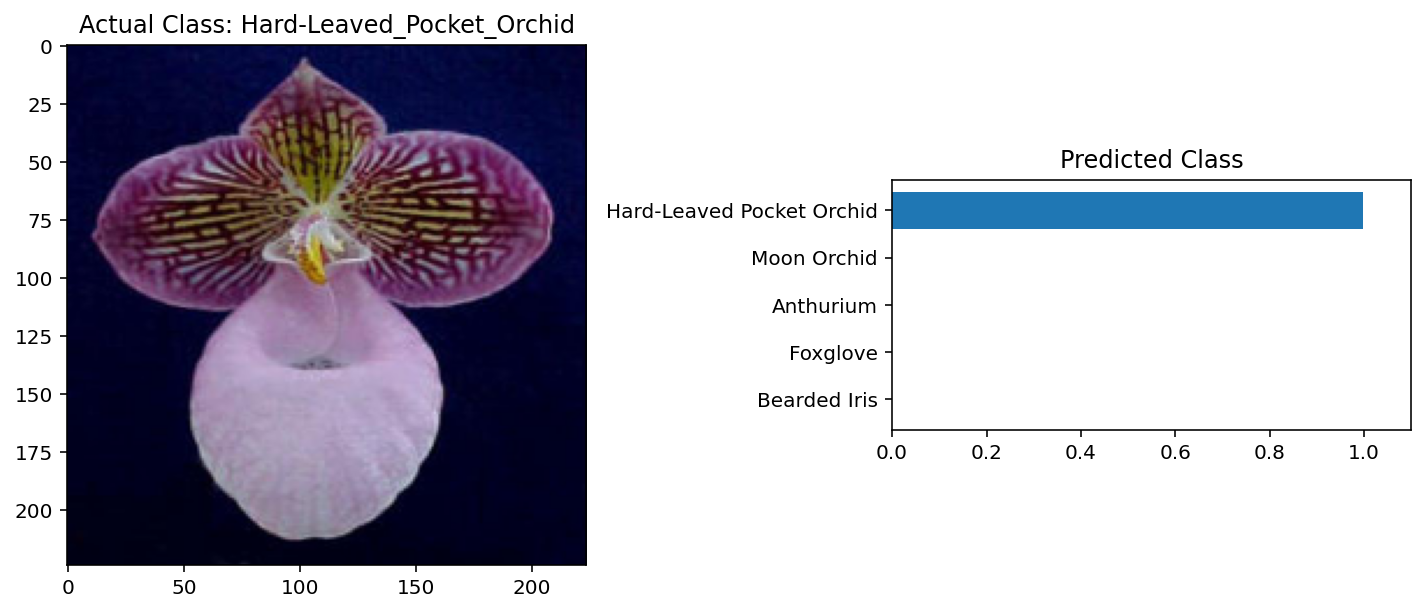

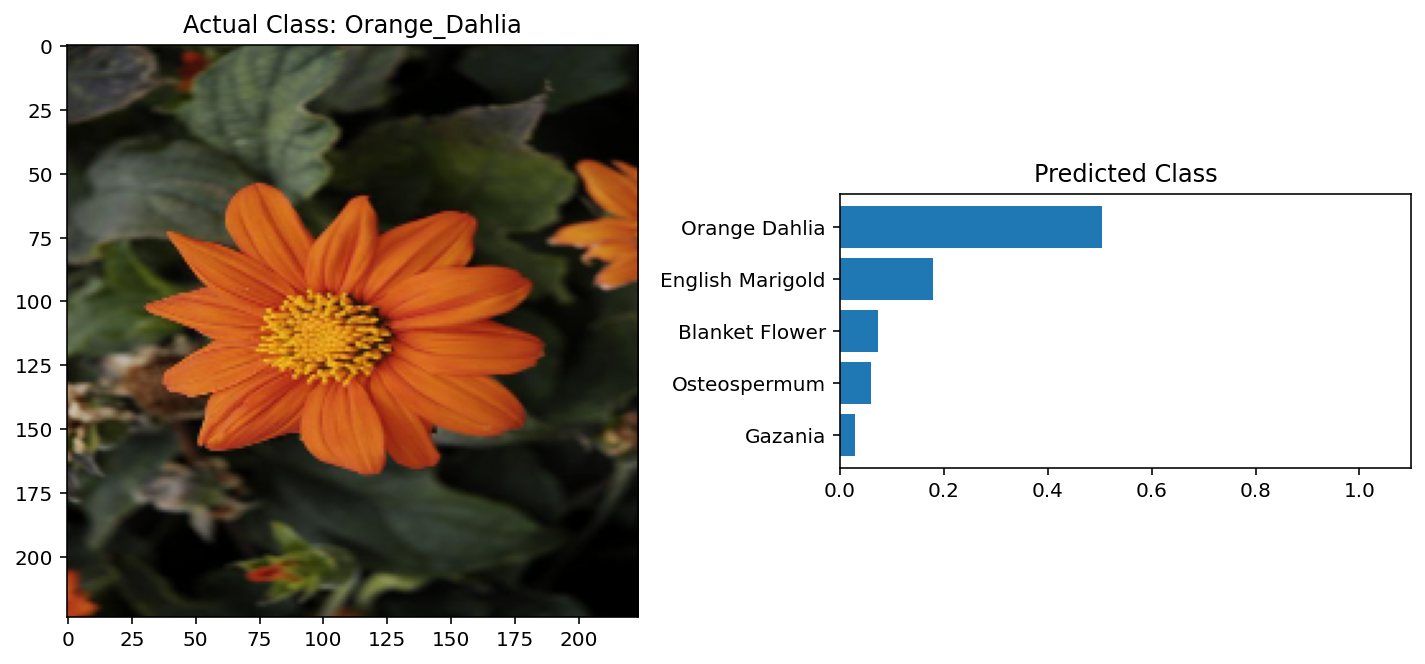

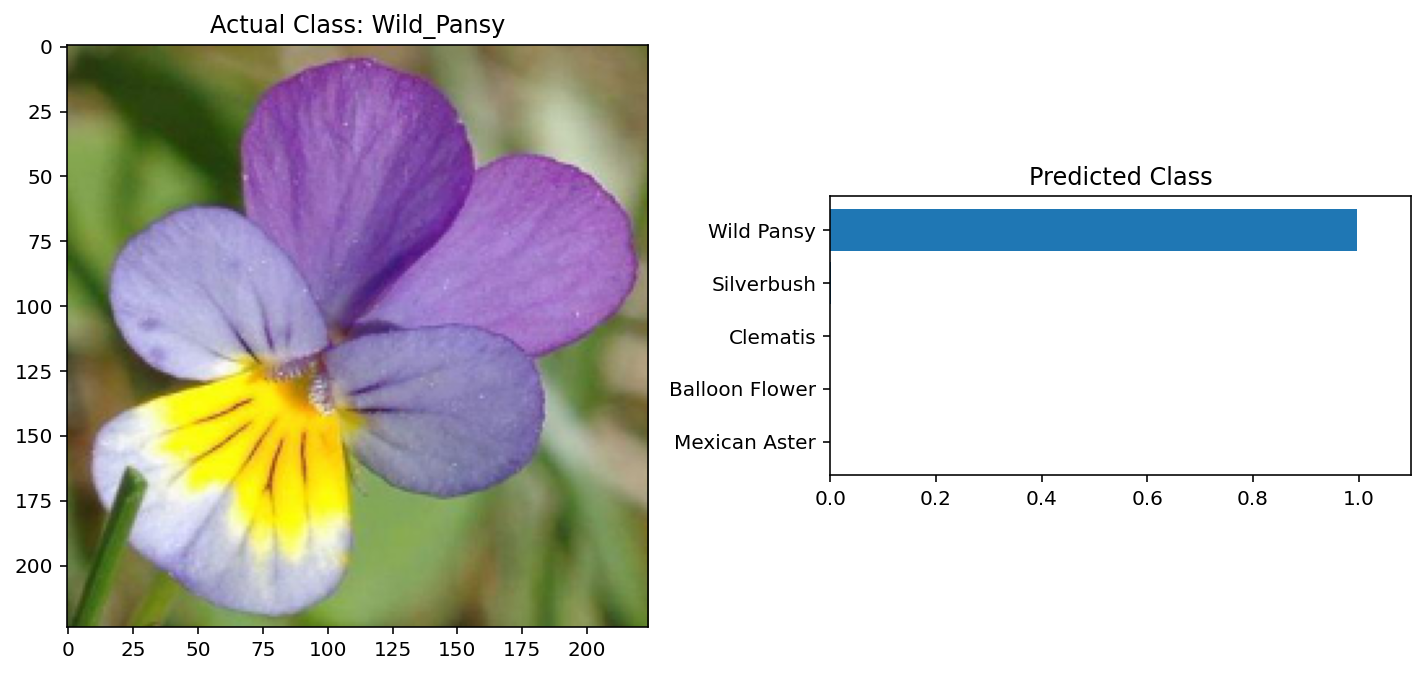

In [39]:
# TODO: Plot the input image along with the top 5 classes
TOP_k = 5
IMAGE_DIR = './test_images/*.jpg'

#Use: 'model', 'Model_Load()', or Model_Load('best'):
#model: the model in memory (assuming entire program is run)
#Model_Load(): last model saved as 't.h5' where t is time at point of save
#Model_Load('best'): best model from compile saved as 'best_model.h5'
TEST_MODEL = Model_Load()

#reload class names
class_names = load_class_names()

#Iterate through all *.jpg files in IMAGE_DIR; return predict; match class_label
image_list = glob.glob(IMAGE_DIR)
for image_path in image_list:
  #run predict to find top k probabilities, classes for images
  probs, classes, processed_test_image = predict(image_path, TEST_MODEL, TOP_k)
  #assign the name to each class number using class_names
  class_label = label_class(classes)

#Sort the labels by probability for bar chart
  unsorted = [(probs, class_label) for class_label, probs in 
                  zip(class_label, probs)]
  sorted_list = sorted(unsorted)

  labels = []; probs = []
  for i in sorted_list:
    probs += [i[0]]
    labels += [i[1]]

#plot processed image, sorted bar chart
  fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
  ax1.imshow(processed_test_image)
  #Label processed image with name from file name
  ax1.set_title("Actual Class: " + os.path.splitext(os.path.basename(image_path))[0].title())
  ax2.barh(labels, probs)
  ax2.set_aspect(0.1)
  ax2.set_xlim(0, 1.1)
  ax2.set_title('Predicted Class')
  plt.tight_layout()
  plt.show()


In [ ]:
#Run this step only if ready to copy model to command line program predict.py
#Ceates saved_model.h5 from latest saved model
with open('file_name.txt', 'r') as f:
  file_base = f.readlines()
file_name = str(file_base[0]) + '.h5'
shutil.copyfile(file_name, 'saved_model.h5')